In [1]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

In [2]:
class SimCLR(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimCLRProjectionHead(512, 2048, 2048)
        self.criterion = NTXentLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

In [8]:
model = SimCLR()

transform = SimCLRTransform(input_size=32, random_gray_scale=1.0)

# dataset = torchvision.datasets.CIFAR10(
#     "datasets/cifar10", download=True, transform=transform, train=True
# )

# ... or MNIST
dataset = torchvision.datasets.MNIST(
    "datasets/mnist-clean-torchvision", download=True, transform=transform, train=True
)

# ... or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [9]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator=accelerator)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [10]:
# training
trainer.fit(model=model, train_dataloaders=dataloader)

# read from checkpoint
# model = SimCLR.load_from_checkpoint(
#     r"lightning_logs\ "
#     )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 5.3 M 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.710    Total estimated model params size (MB)
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\datasets\mnist.py", line 145, in __getitem__
    img = self.transform(img)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\lightly\transforms\multi_view_transform.py", line 33, in __call__
    return [transform(image) for transform in self.transforms]
  File "d:\__repos\ml_concepts\venv\lib\site-packages\lightly\transforms\multi_view_transform.py", line 33, in <listcomp>
    return [transform(image) for transform in self.transforms]
  File "d:\__repos\ml_concepts\venv\lib\site-packages\lightly\transforms\simclr_transform.py", line 183, in __call__
    transformed: Tensor = self.transform(image)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\transforms\transforms.py", line 95, in __call__
    img = t(img)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torch\nn\modules\module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torch\nn\modules\module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\transforms\transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\transforms\functional.py", line 349, in normalize
    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
  File "d:\__repos\ml_concepts\venv\lib\site-packages\torchvision\transforms\_functional_tensor.py", line 926, in normalize
    return tensor.sub_(mean).div_(std)
RuntimeError: output with shape [1, 32, 32] doesn't match the broadcast shape [3, 32, 32]


## Generate embeddings

In [ ]:
import numpy as np
from utils import generate_embeddings
from lightly.transforms.utils import IMAGENET_NORMALIZE

In [ ]:
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=IMAGENET_NORMALIZE["mean"],
            std=IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [ ]:
# note, that this is not 'test' in a train/test sense
# SIMCLR is uses SSL method, so labels doesn't really matter
# test_dataset = torchvision.datasets.CIFAR10(
#     "datasets/test-cifar10", download=True, transform=test_transform, train=False
# )

test_dataset = torchvision.datasets.CIFAR10(
    "datasets/mnist-clean-torchvision", download=True, transform=test_transform, train=False
)

Files already downloaded and verified


In [ ]:
len(dataset)

50000

In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    # this is important!
    shuffle=False,
    drop_last=True,
    num_workers=8,
)

In [ ]:
embeddings = generate_embeddings(model, test_dataloader)


In [ ]:
print(type(embeddings))
print(len(embeddings))
print(embeddings.shape)

<class 'torch.Tensor'>
9984
torch.Size([9984, 512])


### Random

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
num_principal_components = 3
n_clusters = 20

In [ ]:
pca = PCA(n_components=num_principal_components)
embeddings_reduced = pca.fit_transform(embeddings.to("cpu").numpy())

kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(embeddings_reduced)
centroids = kmeans.cluster_centers_

In [ ]:
centroids.shape

(20, 3)

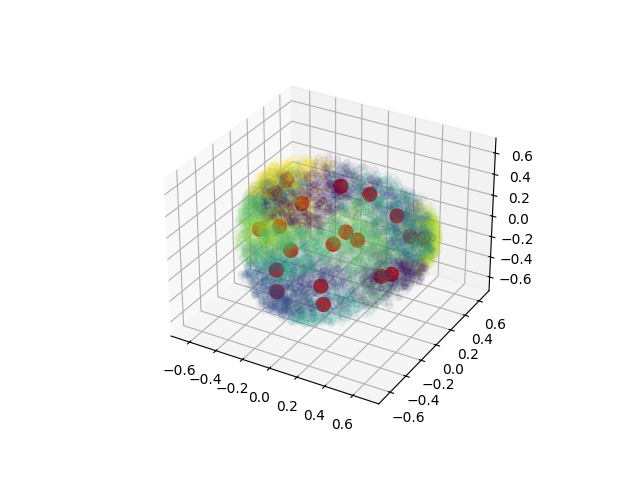

In [ ]:
ax = plt.figure().add_subplot(projection="3d")

ax.scatter(
    embeddings_reduced[:, 0],
    embeddings_reduced[:, 1],
    embeddings_reduced[:, 2],
    c=labels,
    alpha=0.05,
)

ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    c="red",
    s=100,
    alpha=1.0,
)

plt.show()